## Rectangle/Face Experiment Analyses

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
from skgof import ks_test, cvm_test, ad_test
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division

### Functions to return accuracy and test for bias

In [2]:
def accuracy(res_cat, true_cat):
    acc = sum(res_cat == true_cat)/float(len(true_cat))
    hits = sum((res_cat == 1) & (true_cat ==1))/float(sum(true_cat == 1))
    fps = sum((res_cat == 1) & (true_cat ==2))/float(sum(true_cat == 2))
    return [acc, hits, fps]

def bias_test(p_obs, n):
    ex = [n/2, n/2]
    obs = [n * p_obs, n * (1-p_obs)]
    chi2 = chisquare(ex, obs)
    if chi2.pvalue < .05:
        return True
    else:
        return False

### Parse the data

In [3]:
# parse the data
path = ''
data_dir = ['FaceFace', 'FacePetal', 'PetalFace', 'PetalPetal']
all_data = {}
stims = ['true-false-false',
       'false-true-false',
       'false-false-true',
       'true-true-false',
       'true-false-true',
       'false-true-true',
       'true-true-true']
for dir in data_dir:
    all_data[dir] = {}
    for block, blockfile in enumerate(['/rawdata1', '/rawdata2']):
        sub = 1 # count subjects for each experiment
        for filename in os.listdir(path + dir + blockfile):
            # ignore hidden files
            if filename.startswith('.'):
               continue 
            df = pd.read_csv(path + dir + blockfile + '/' + filename)
            # get overall accuracy, hits, and fps
            acc_tot, hits_tot, fps_tot = accuracy(df['response'].values, df['true_category'].values)
            # get accuracy per stimulus
            acc_per_stim = []
            hits_per_stim = []
            fps_per_stim = []
            for stim in stims:
                res_cat = df.loc[df['stimuli'] == stim, 'response'] 
                true_cat = df.loc[df['stimuli'] == stim, 'true_category']
                acc, hits, fps = accuracy(res_cat, true_cat)
                acc_per_stim.append(acc)
                hits_per_stim.append(hits)
                fps_per_stim.append(fps)
            # get proportion of responses in Cat 1
            pC1_tot = np.sum(df['response'].values == 1)/float(len(df['response'].values))
            # store the data
            if sub not in all_data[dir]:
                all_data[dir][sub] = {}   
            all_data[dir][sub]['block_' + str(block + 1)] = \
                                {'id': df['workerId'][0],
                                 'acc': acc_tot, 
                                 'hits': hits_tot, 
                                 'fps': fps_tot,
                                 'acc_per_stim': acc_per_stim, 
                                 'hits_per_stim': hits_per_stim, 
                                 'fps_per_stim': fps_per_stim,
                                 'pC1_tot': pC1_tot}
            sub += 1

### Check for bias (skip these blocks to include biased subjects)



In [4]:
n = 200
bias_count = 0
for exp in all_data:
    for sub in all_data[exp]:
        p_obs =  (all_data[exp][sub]['block_1']['pC1_tot'] + all_data[exp][sub]['block_2']['pC1_tot']) / 2
        bias = bias_test(p_obs, n)
        if bias:
            bias_count += 1
        all_data[exp][sub]['bias'] = bias
print('Number of biased subs: ', bias_count)        

('Number of biased subs: ', 23)


In [5]:
# drop biased subs
for exp in all_data:
    for sub in list(all_data[exp]):
        if all_data[exp][sub]['bias']:
            all_data[exp].pop(sub)
            
# get rid of bias key
for exp in all_data:
    for sub in list(all_data[exp]):
        all_data[exp][sub].pop('bias')

### Accuracy per stimulus

In [6]:
# get accuracy per stim per block per experiment
acc_per_stim = {}
for exp in all_data:
    acc_per_stim[exp] = {}
    for sub in all_data[exp]:
        for block in all_data[exp][sub]:
            if block not in acc_per_stim[exp]:
                acc_per_stim[exp][block] = np.empty([0,7])
            acc_per_stim[exp][block] = np.vstack([acc_per_stim[exp][block], all_data[exp][sub][block]['acc_per_stim']])
        

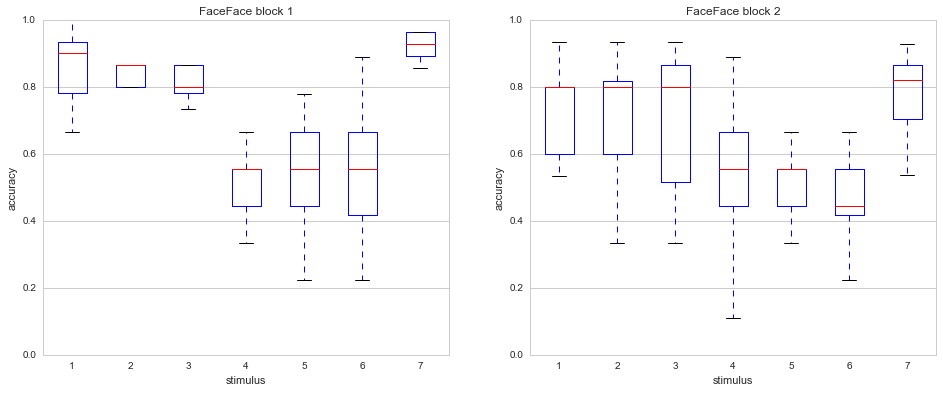

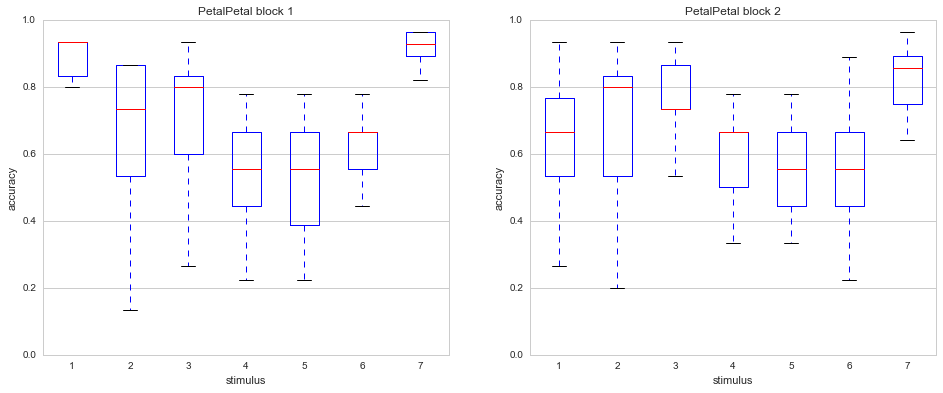

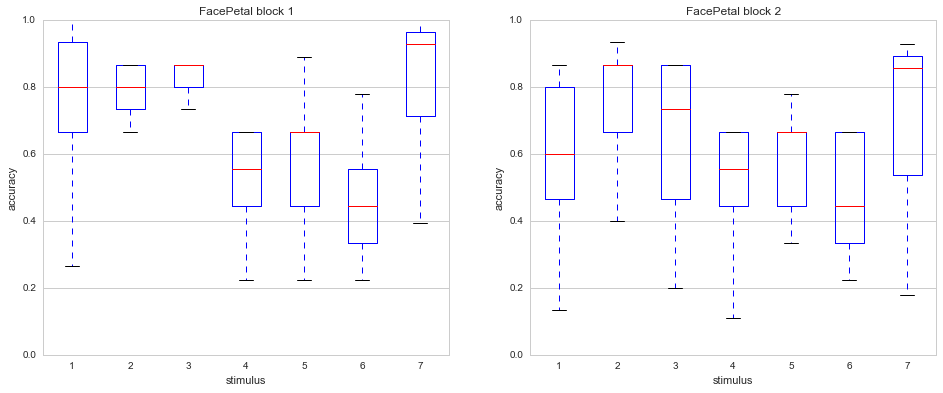

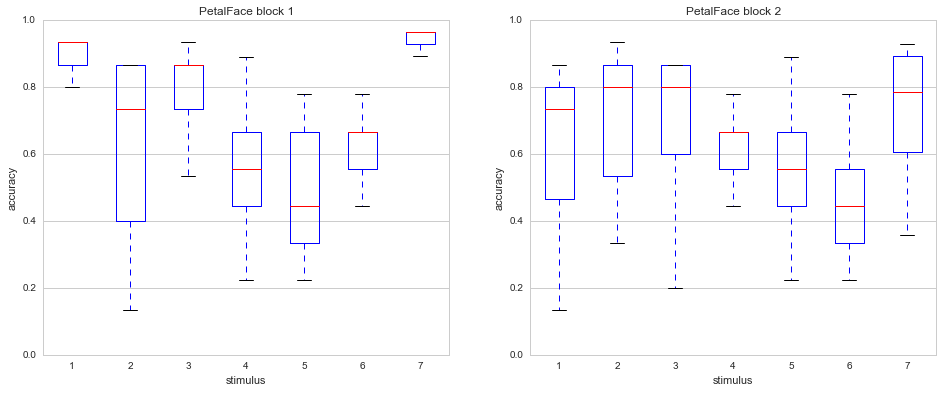

In [7]:
# plot accuracy per stim boxplots
#fig = plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
for exp in acc_per_stim:
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,2,1)
    plt.boxplot(acc_per_stim[exp]['block_1'])
    plt.ylim([0,1])
    plt.title(exp + ' block 1')
    plt.ylabel('accuracy')
    plt.xlabel('stimulus')
    plt.grid('off', axis='x')

    ax = fig.add_subplot(1,2,2)
    plt.boxplot(acc_per_stim[exp]['block_2']) 
    plt.ylim([0,1])
    plt.title(exp + ' block 2')
    plt.ylabel('accuracy')
    plt.xlabel('stimulus')
    plt.grid('off', axis='x')
    
plt.show()    

# Per-stimulus analysis

### Get difference between blocks per stim 

In [8]:
# get block 1 - block 2 per stim
acc_dif_per_stim = {}
for exp in acc_per_stim:
    acc_dif_per_stim[exp] = acc_per_stim[exp]['block_1'] - acc_per_stim[exp]['block_2']
    

### Plot difference between blocks

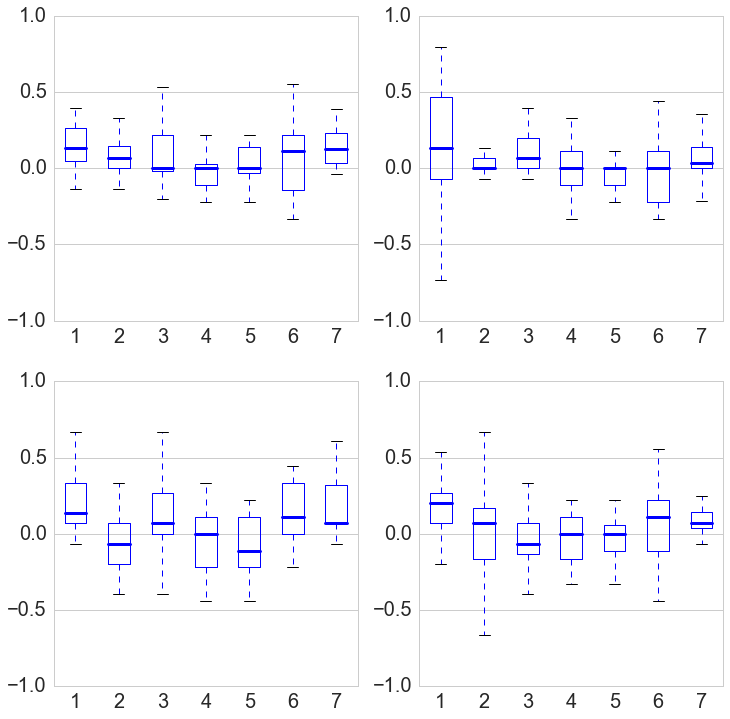

In [9]:
fig = plt.figure(figsize=(12,12))
exps = ['FaceFace', 'FacePetal', 'PetalFace', 'PetalPetal']
for count, exp in enumerate(exps):
    ax = fig.add_subplot(2,2, count + 1)
    plt.boxplot(acc_dif_per_stim[exp], medianprops = {'color': 'b', 'LineWidth': 3})
    plt.ylim((-1, 1))
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.tick_params(labelsize=20)
plt.show()     

### Median accuracy difference per stim

In [10]:
# get median dif per stim
med_acc_dif_per_stim = {}
for exp in acc_dif_per_stim:
        med_acc_dif_per_stim[exp] = np.median(acc_dif_per_stim[exp], axis=0)
         

### Subtract the baseline

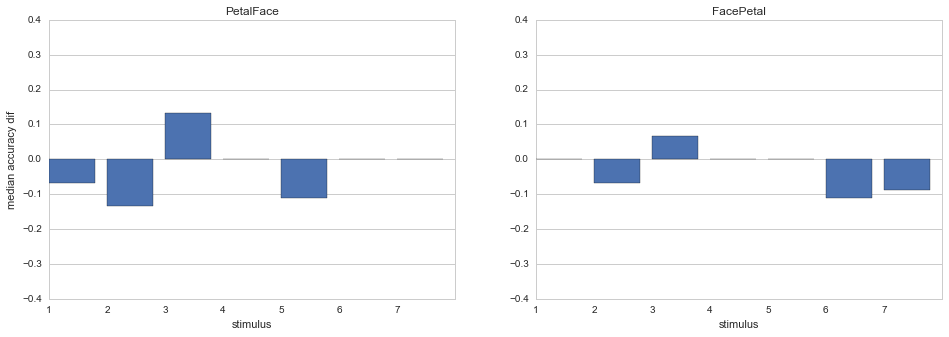

In [11]:
# get difference between median differences

exps = ['PetalPetal', 'PetalFace', 'FacePetal', 'FaceFace']

c1=exps[1]
bc1=exps[0]
c2=exps[2]
bc2=exps[3]



med_dif = {}
med_dif[c1] = med_acc_dif_per_stim[c1] - med_acc_dif_per_stim[bc1]
med_dif[c2] = med_acc_dif_per_stim[c2] - med_acc_dif_per_stim[bc2]

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.bar(range(len(med_dif[c1])), med_dif[c1], zorder=3)
plt.title(c1)
plt.ylabel('median accuracy dif')
plt.xlabel('stimulus')
plt.xticks(range(len(med_dif[c1])), np.arange(len(med_dif[c1]))+1)
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.ylim([-.4, .4])

ax = fig.add_subplot(1,2,2)
ax.bar(range(len(med_dif[c2])), med_dif[c2], zorder=3)
plt.title(c2)
plt.xlabel('stimulus')
plt.xticks(range(len(med_dif[c2])), np.arange(len(med_dif[c2]))+1)
plt.ylim([-.4, .4])
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.show()


### Combine FaceRect and RectFace conditions

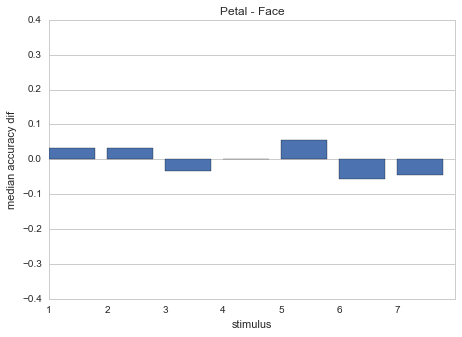

In [12]:
# get average of RectFace and -1 * FaceRect
med_dif_avg = np.mean(np.array([med_dif[c2], -1 * med_dif[c1]]), axis=0)

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.bar(range(len(med_dif_avg)), med_dif_avg, zorder=3)
plt.title('Petal - Face')
plt.ylabel('median accuracy dif')
plt.xlabel('stimulus')
plt.xticks(range(len(med_dif_avg)), np.arange(len(med_dif_avg))+1)
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.ylim([-.4, .4])

plt.show()

### Get median difference across stimuli

0.0


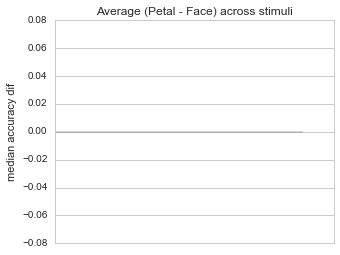

In [13]:
avg_med_dif = np.median(med_dif_avg)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
print avg_med_dif
ax.bar([0], avg_med_dif)
plt.title('Average (Petal - Face) across stimuli')
plt.ylabel('median accuracy dif')
plt.xlabel(' ')
plt.xticks([0],'')
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.ylim([-0.08, .08])

plt.show()

### Bootstrap

In [14]:
# bootstrap
N = np.sum(np.array([[2, 2, 2, 6, 6, 6, 27],[13, 13, 13, 3, 3, 3, 1]]), axis=0)
Nsams = 10000
bootstrap = {}
for exp in acc_per_stim:
    bootstrap[exp] = {}
    for block in acc_per_stim[exp]:
        bootstrap[exp][block] = np.empty((acc_per_stim[exp][block].shape[0],
                                          acc_per_stim[exp][block].shape[1], 
                                          Nsams))
        for sub in range(acc_per_stim[exp][block].shape[0]):
            for stim in range(acc_per_stim[exp][block].shape[1]):
                p = acc_per_stim[exp][block][sub, stim]
                bootstrap[exp][block][sub, stim, :] = np.random.binomial(N[stim], p, Nsams) / (N[stim])

# get difference between bootstrapped accuracies
acc_dif_per_stim_bs = {}
for exp in bootstrap:
    acc_dif_per_stim_bs[exp] = bootstrap[exp]['block_1'] - bootstrap[exp]['block_2']

# get distribution of median differences per stim 
med_acc_dif_per_stim_bs = {}
for exp in acc_dif_per_stim_bs:
    med_acc_dif_per_stim_bs[exp] = np.median(acc_dif_per_stim_bs[exp], axis=0)

# get differences between medians
med_acc_dif_bs = {}
med_acc_dif_bs['FacePetal'] = med_acc_dif_per_stim_bs['FacePetal'] - med_acc_dif_per_stim_bs['FaceFace']
med_acc_dif_bs['PetalFace'] = med_acc_dif_per_stim_bs['PetalFace'] - med_acc_dif_per_stim_bs['PetalPetal']

# get average of RectFace and -1 * FaceRect
med_dif_avg_bs = np.mean(np.array([med_acc_dif_bs['PetalFace'], -1 * med_acc_dif_bs['FacePetal']]), axis=0)

# get median dif across stimuli
avg_med_dif_bs = np.median(med_dif_avg_bs, axis=0)

# get 95% CI on bootstrapped medians
med_acc_dif_CI = {}
med_acc_dif_CI['FacePetal'] = np.percentile(med_acc_dif_bs['FacePetal'], [.025, .975], axis=1)
med_acc_dif_CI['PetalFace'] = np.percentile(med_acc_dif_bs['PetalFace'], [.025, .975], axis=1)

med_acc_dif_err = {}
med_acc_dif_err['FacePetal'] = med_acc_dif_CI['FacePetal'][1] - med_acc_dif_CI['FacePetal'][0] 
med_acc_dif_err['PetalFace'] = med_acc_dif_CI['PetalFace'][1] - med_acc_dif_CI['PetalFace'][0]

# get 95% CI on bootstrapped average of RectFace and -1 * FaceRect
med_dif_avg_CI = {}
med_dif_avg_CI = np.percentile(med_dif_avg_bs, [.025, .975], axis=1)

med_dif_avg_err = {}
med_dif_avg_err = med_dif_avg_CI[1] - med_dif_avg_CI[0]

# get 95% CI on average dif across stimuli
avg_med_dif_err = np.percentile(avg_med_dif_bs,[.025, .975])


### Plot median accuracy difs with bootstrapped error bars 

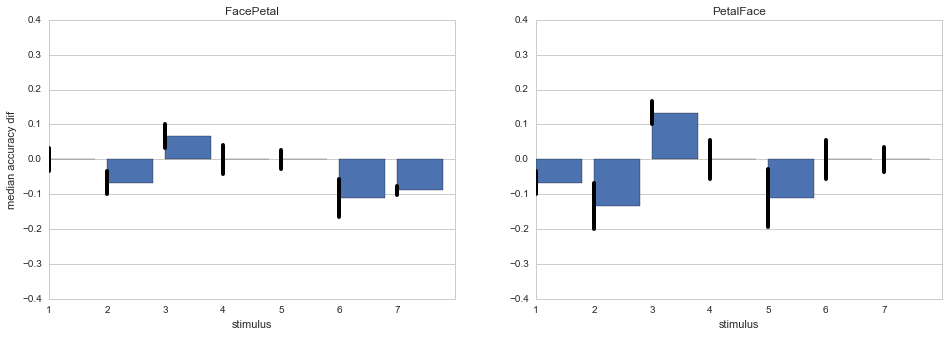

In [15]:
# plot
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.bar(range(len(med_dif['FacePetal'])), med_dif['FacePetal'], zorder=3)
# error bars
for stim in range(med_dif['FacePetal'].shape[0]):
    plt.plot([stim, stim], [med_dif['FacePetal'][stim] - med_acc_dif_err['FacePetal'][stim] / float(2),
                            med_dif['FacePetal'][stim] + med_acc_dif_err['FacePetal'][stim] / float(2)],
                            'k', LineWidth=4, zorder=3)

plt.title('FacePetal')
plt.ylabel('median accuracy dif')
plt.xlabel('stimulus')
plt.xticks(range(len(med_dif['FacePetal'])), np.arange(len(med_dif['FacePetal']))+1)
plt.ylim([-.4, .4])
plt.grid('off', axis='x')
ax.yaxis.grid(True, zorder=0)

ax = fig.add_subplot(1,2,2)
ax.bar(range(len(med_dif['PetalFace'])), med_dif['PetalFace'], zorder=3)
# error bars
for stim in range(med_dif['PetalFace'].shape[0]):
    plt.plot([stim, stim], [med_dif['PetalFace'][stim] - med_acc_dif_err['PetalFace'][stim] / float(2),
                            med_dif['PetalFace'][stim] + med_acc_dif_err['PetalFace'][stim] / float(2)],
                            'k', LineWidth=4, zorder=3)
plt.title('PetalFace')
plt.xlabel('stimulus')
plt.xticks(range(len(med_dif['FacePetal'])), np.arange(len(med_dif['FacePetal']))+1)
plt.ylim([-.4, .4])
plt.grid('off', axis='x')
#ax.yaxis.grid(True, zorder=0)
plt.show()




### Combine RectFace and FaceRect

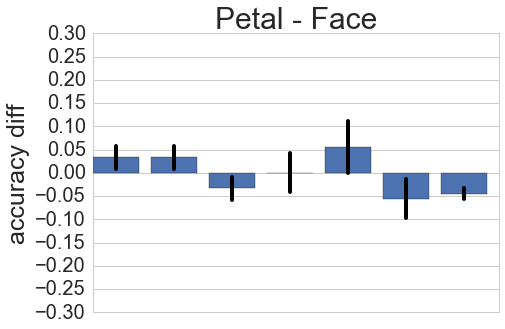

In [20]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.bar(range(len(med_dif_avg)), med_dif_avg, zorder=3)

# error bars
for stim in range(med_dif_avg.shape[0]):
    plt.plot([stim+0.4, stim+0.4], [med_dif_avg[stim] - med_dif_avg_err[stim] / 2,
                            med_dif_avg[stim] + med_dif_avg_err[stim] / 2],
                            'k', LineWidth=4, zorder=3)


plt.title('Petal - Face', fontsize=30)
plt.ylabel('accuracy diff', fontsize=25)
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.yticks(np.arange(-0.3,0.35,0.05))
ax.tick_params(labelsize=20)
ax.set_xticks([])




plt.show()

### Average difference across stimuli

[ 0.03333333  0.025     ]
[-0.03333333 -0.025     ]


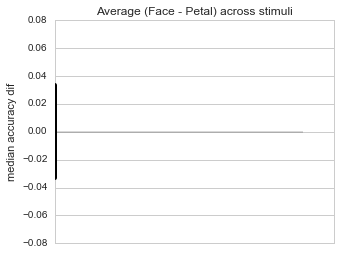

In [28]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.bar([0], avg_med_dif)
plt.plot([0, 0], [avg_med_dif - avg_med_dif_err / 2,
                  avg_med_dif + avg_med_dif_err / 2,],
                  'k', LineWidth=4, zorder=3)

print avg_med_dif - avg_med_dif_err / 2
print avg_med_dif + avg_med_dif_err / 2
plt.title('Average (Face - Petal) across stimuli')
plt.ylabel('median accuracy dif')
plt.xlabel(' ')
plt.xticks([0],'')
ax.yaxis.grid(True, zorder=0)
ax.xaxis.grid(False)
plt.ylim([-0.08, .08])

plt.show()

After dropping biased subjects, the net gain in accuracy for Rectangles is approximately 4.5% and the difference between Rectangles and Faces is significant.